In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px

from wordcloud import WordCloud
import re
from nltk.corpus import stopwords
import seaborn as sns

from sklearn.model_selection import KFold, train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [ ]:
#training = pd.read_csv('C:/Users/Alvis/STA142A/train.csv')
#test = pd.read_csv('C:/Users/Alvis/STA142A/test.csv')
#test_labels = pd.read_csv("C:/Users/Alvis/STA142A/test_labels.csv")

In [ ]:
#training = pd.read_csv("C:/Users/Falak/Desktop/NLP/train.csv")
#test = pd.read_csv("C:/Users/Falak/Desktop/NLP/test.csv")
#test_labels = pd.read_csv("C:/Users/Falak/Desktop/NLP/test_labels.csv")

In [3]:
training = pd.read_csv('C:/Users/dlsim/Documents/_College/1 UC Davis/4 Senior Year/Win - STA 142a - Statistical Learning I/ipynb files/142 Final Project/train.csv')
test = pd.read_csv('C:/Users/dlsim/Documents/_College/1 UC Davis/4 Senior Year/Win - STA 142a - Statistical Learning I/ipynb files/142 Final Project/test.csv')
test_labels = pd.read_csv('C:/Users/dlsim/Documents/_College/1 UC Davis/4 Senior Year/Win - STA 142a - Statistical Learning I/ipynb files/142 Final Project/test_labels.csv')

In [4]:
# Observing data
print(f"Train Data dimensions are {training.shape}")
#print(f"Train Data dimensions are {test.shape}")

training.head(3)

Train Data dimensions are (159571, 8)


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0


In [5]:
# Visualization - https://www.kaggle.com/sasidharturaga/eda-step-wise-preprocess-and-lstm-classifier
import plotly.express as px

df1 = pd.DataFrame(training[training.columns[2:]].sum(axis=0)).reset_index() 
df1["Type of Comment Violation"] = df1["index"]
df1["Number of Comments"] = df1[0]
df1.head(6)

,index,0,Type of Comment Violation,Number of Comments
0,toxic,15294,toxic,15294
1,severe_toxic,1595,severe_toxic,1595
2,obscene,8449,obscene,8449
3,threat,478,threat,478
4,insult,7877,insult,7877
5,identity_hate,1405,identity_hate,1405


In [6]:
df2 = pd.DataFrame(pd.DataFrame(training[training.columns[2:]].sum(axis=1)).reset_index()[0].value_counts())
df2["Number of Sentences"]=df2[0]
df2["Number of Types of Violations"]=df2.index
df2

,0,Number of Sentences,Number of Types of Violations
0,143346,143346,0
1,6360,6360,1
3,4209,4209,3
2,3480,3480,2
4,1760,1760,4
5,385,385,5
6,31,31,6


In [ ]:
#Display of comments 
df1 = df1.sort_values(0, ascending=False) 
fig1 = px.bar(df1, x="Type of Comment Violation", y="Number of Comments", title="No. of comments per label",text="Number of Comments")
fig1.show()

fig2 = px.bar(df2, x="Number of Types of Violations", y="Number of Sentences", title="Number of Comments by Amount of Labels", text="Number of Sentences")
fig2.show()

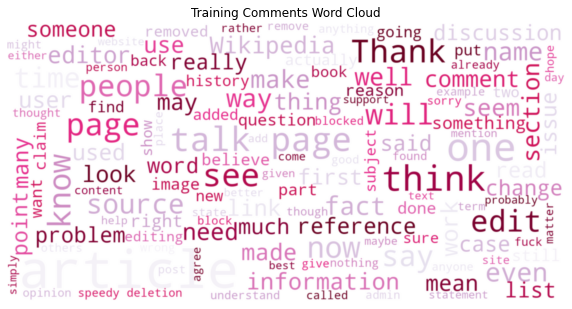

In [8]:
from wordcloud import WordCloud
words = ' '.join([text for text in training['comment_text']])

word_cloud = WordCloud(
                       width=1600,
                       height=800,
                       colormap='PuRd', 
                       margin=0,
                       max_words=500, # Maximum numbers of words we want to see 
                       min_word_length=3, # Minimum numbers of letters of each word to be part of the cloud
                       max_font_size=150, min_font_size=30,  # Font size range
                       background_color="white").generate(words)

plt.figure(figsize=(10, 16))
plt.imshow(word_cloud, interpolation="gaussian")
plt.title("Training Comments Word Cloud")
plt.axis("off")
plt.show()

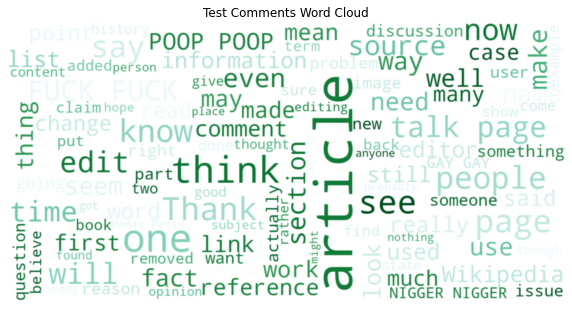

In [9]:
words = ' '.join([text for text in test['comment_text']])

word_cloud = WordCloud(
                       width=1600,
                       height=800,
                       colormap='BuGn', 
                       margin=0,
                       max_words=500, # Maximum numbers of words we want to see 
                       min_word_length=3, # Minimum numbers of letters of each word to be part of the cloud
                       max_font_size=150, min_font_size=30,  # Font size range
                       background_color="white").generate(words)

plt.figure(figsize=(10, 16))
plt.imshow(word_cloud, interpolation="gaussian")
plt.title("Test Comments Word Cloud")
plt.axis("off")
plt.show()

In [10]:

# Preprocessing
import re
from nltk.corpus import stopwords
stop = stopwords.words('english')

def preprocess(training, test):
    training['clean'] = training.apply(lambda row: row['comment_text'].replace("\n"," "), axis=1) #removes new line character
    test['clean'] = test.apply(lambda row: row['comment_text'].replace("\n"," "), axis=1)

    #removes urls
    training['clean'] = training.apply(lambda row: re.sub('http://\S+|https://\S+', '', row['clean']), axis=1)
    test['clean'] = test.apply(lambda row: re.sub('http://\S+|https://\S+', '',row['clean']), axis=1)

    #remove all non-alphanumeric values
    training['clean'] = training.apply(lambda row: re.sub('[^A-Za-z0-9\' ]+', '',row['clean']), axis=1)
    test['clean'] = test.apply(lambda row: re.sub('[^A-Za-z0-9\' ]+', '',row['clean']), axis=1)

    #remove stopwords as they occupy major chunk of the vocabulary
    training['clean'] = training['clean'].apply(lambda x: ' '.join([word for word in x.split() if not word in (stop)]))
    test['clean'] = test['clean'].apply(lambda x: ' '.join([word for word in x.split() if not word in (stop)]))

    #removes all additional spaces
    training['clean'] = training.apply(lambda row: re.sub(' +', ' ', row['clean']).strip(), axis=1)
    test['clean'] = test.apply(lambda row: re.sub(' +', ' ', row['clean']).strip(), axis=1)
    
    #lowercase end result
    training['clean'] = training['clean'].str.lower()
    test = test['clean'].str.lower()

preprocess(training, test)
training.head(10)
test.head(10)

,id,comment_text,clean
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...,Yo bitch Ja Rule succesful ever whats hating s...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...,From RfC The title fine IMO
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",Sources Zawe Ashton Lapland
3,00017563c3f7919a,":If you have a look back at the source, the in...",If look back source information I updated corr...
4,00017695ad8997eb,I don't anonymously edit articles at all.,I anonymously edit articles
5,0001ea8717f6de06,Thank you for understanding. I think very high...,Thank understanding I think highly would rever...
6,00024115d4cbde0f,Please do not add nonsense to Wikipedia. Such ...,Please add nonsense Wikipedia Such edits consi...
7,000247e83dcc1211,:Dear god this site is horrible.,Dear god site horrible
8,00025358d4737918,""" \n Only a fool can believe in such numbers. ...",Only fool believe numbers The correct number l...
9,00026d1092fe71cc,== Double Redirects == \n\n When fixing double...,Double Redirects When fixing double redirects ...


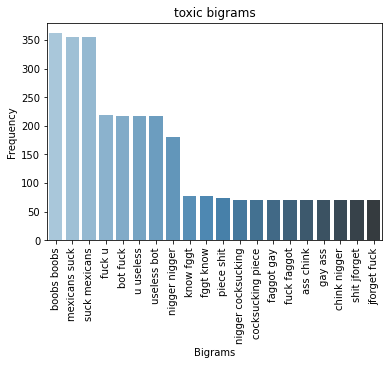

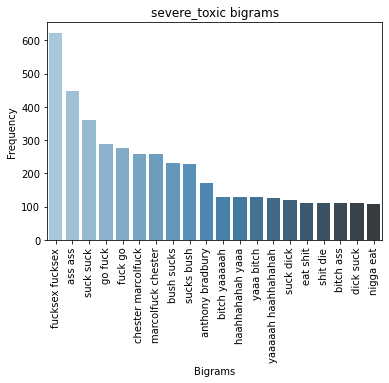

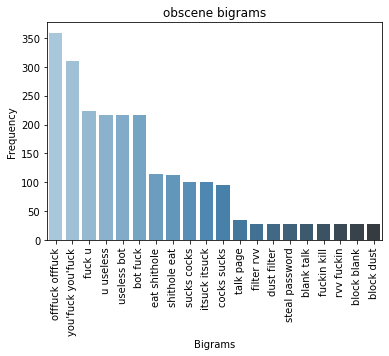

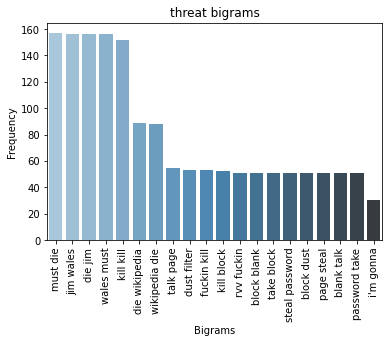

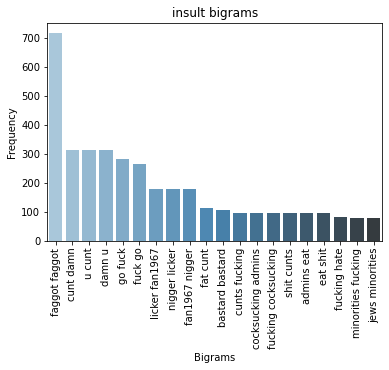

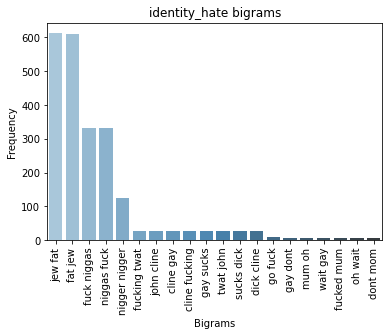

In [11]:
import seaborn as sns
#Bigram analysis - see https://www.kaggle.com/swathi314/toxic-comments-exploratory-analysis-baseline#Toxic-comment-classification
#need to rewrite two functions, gram_analysis and gram_freq to generate result below
#Bigram oneliner: http://www.locallyoptimal.com/blog/2013/01/20/elegant-n-gram-generation-in-python/

def bigram_gen(train):
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in train.split(" ") if token != "" if token not in stop_words if len(token) < 15]
    ngrams = zip(*[tokens[i:] for i in range(2)])
    final_tokens = [" ".join(j) for j in ngrams]
    return final_tokens

def bigram_plot(train, categ_col):
    freq_text = " ".join(train[train[categ_col]==1]['clean'].sample(250).values)
    tokens = bigram_gen(freq_text)
    token_freq = pd.DataFrame(data=[tokens, np.ones(len(tokens))]).T.groupby(0).sum().reset_index()
    token_freq.columns = ['Bigrams','Frequency']
    token_freq = token_freq.sort_values(by='Frequency',ascending=False)
    
    plt.figure()
    plt.title("{} bigrams".format(categ_col))
    sns.barplot(x='Bigrams', y='Frequency', data=token_freq.iloc[:20], palette = "Blues_d")
    plt.xticks(rotation=90)
    plt.show()
    return 

for i in ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']: 
    bigram_plot(training, i)